<a href="https://colab.research.google.com/github/harsh-manjhi/data-science-with-python-internship/blob/main/DATA_SCIENCE_WITH_PYTHON_HARSH_TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3 — Customer Segmentation using Clustering
**Student:** Harsh  
**Domain:** Data Science with Python

**Note:** The assignment references `customer_data.csv` but no download link was provided. This notebook uses a **synthetic, realistic customer dataset** (Age, Annual Income, Spending Score) generated programmatically to demonstrate clustering steps. If you receive the real `customer_data.csv`, replace the data-loading cell with `pd.read_csv('path/to/customer_data.csv')`.


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style="whitegrid")



In [ ]:
np.random.seed(42)
n = 300

ages = np.random.normal(40, 12, n).astype(int)
ages = np.clip(ages, 18, 80)

annual_income = np.random.normal(60000, 25000, n).astype(int)
annual_income = np.clip(annual_income, 8000, 200000)


In [ ]:
spending_score = np.clip((100 - (annual_income / annual_income.max())*50 + np.random.normal(0,12,n)), 1, 100).astype(int)

customer_id = np.arange(1, n+1)

df = pd.DataFrame({
    'CustomerID': customer_id,
    'Age': ages,
    'AnnualIncome': annual_income,
    'SpendingScore': spending_score
})

# Quick peek
df.head()

,CustomerID,Age,AnnualIncome,SpendingScore
0,1,45,39275,94
1,2,38,45995,72
2,3,47,78682,81
3,4,58,75259,88
4,5,37,59477,83


## 1) Explore the dataset
Check shape, missing values, datatypes, and basic statistics.


In [ ]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
df.describe().T


Shape: (300, 4)

Missing values:
 CustomerID       0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

Data types:
 CustomerID       int64
Age              int64
AnnualIncome     int64
SpendingScore    int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
CustomerID,300.0,150.500000,86.746758,1.0,75.75,150.5,225.25,300.0
Age,300.0,39.570000,11.410189,18.0,31.00,40.0,47.00,80.0
AnnualIncome,300.0,59527.953333,23889.089489,8000.0,42389.00,59530.5,75408.25,136972.0
SpendingScore,300.0,78.216667,14.034467,40.0,69.00,78.0,89.00,100.0


## 2) Preprocessing
- No missing values in synthetic data; if present, we would impute or drop.
- We will scale features (StandardScaler) before clustering because clustering depends on scale.
- We'll use Age, AnnualIncome, SpendingScore as features.


In [ ]:
features = ['Age', 'AnnualIncome', 'SpendingScore']
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Put scaled features into DataFrame for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()


,Age,AnnualIncome,SpendingScore
0,0.476686,-0.849207,1.126491
1,-0.137826,-0.567437,-0.443697
2,0.652260,0.803130,0.198653
3,1.617922,0.659604,0.698258
4,-0.225614,-0.002136,0.341397


## 3) Choose optimal number of clusters
We will use:
- Elbow method (WCSS vs k)
- Silhouette score for k range 2..10


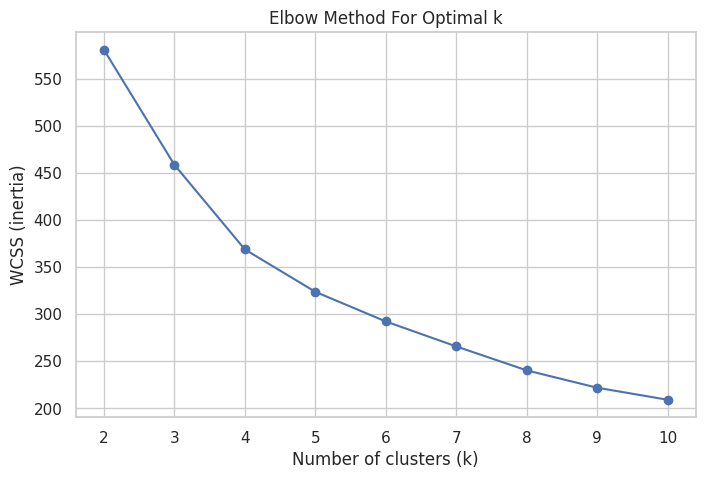

,k,WCSS,Silhouette
0,2,580.739473,0.307712
1,3,458.614074,0.264916
2,4,368.825641,0.273730
3,5,323.822995,0.247576
4,6,292.364001,0.239068
5,7,265.874011,0.244879
6,8,240.435422,0.245868
7,9,222.025596,0.240178
8,10,209.241351,0.230096


In [9]:
wcss = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    labels = km.labels_
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure()
plt.plot(list(K_range), wcss, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method For Optimal k')
plt.xticks(list(K_range))
plt.grid(True)
plt.show()

pd.DataFrame({'k': list(K_range), 'WCSS': wcss, 'Silhouette': sil_scores})

## 4) Apply KMeans with chosen k
Pick the k based on elbow+silhouette. We'll pick the k with a balance of low WCSS and high silhouette.


In [11]:
# --- choose k (adjust if needed after you inspect plots) ---
chosen_k = 4   # change this after inspecting elbow/silhouette if you want

kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# attach labels to original df
df['Cluster'] = labels
df['Cluster'] = df['Cluster'].astype(int)
df.groupby('Cluster')[features].mean().round(2)


,Age,AnnualIncome,SpendingScore
Cluster,,,
0,50.16,65660.94,73.01
1,42.79,37602.22,93.13
2,28.33,56282.85,80.17
3,35.06,91144.18,58.94


## 5) PCA to reduce to 2D for visualization of clusters
We will apply PCA on scaled data and plot the clusters and centroids.


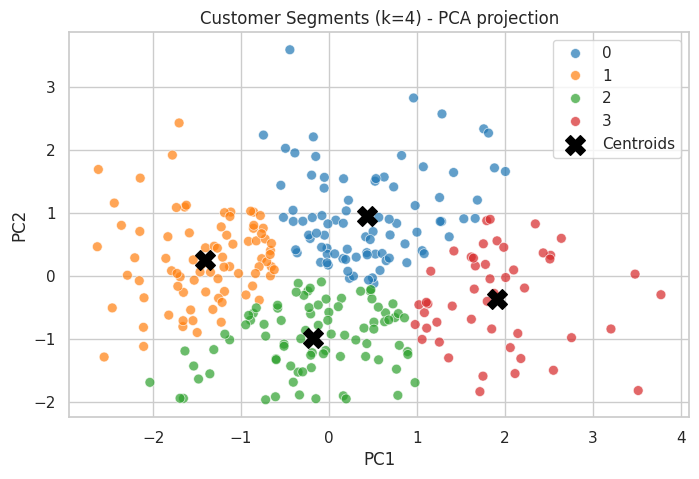

In [12]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)
comp_df = pd.DataFrame(components, columns=['PC1','PC2'])
comp_df['Cluster'] = labels

# Centroids in PCA space
centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.figure()
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='tab10', data=comp_df, s=50, alpha=0.7)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='X', s=200, color='black', label='Centroids')
plt.title(f'Customer Segments (k={chosen_k}) - PCA projection')
plt.legend()
plt.show()


## 6) Pairwise relationships and centroid values
- Pairplot colored by cluster (use a sample if dataset is large)
- Show cluster centroids in original scale for interpretation


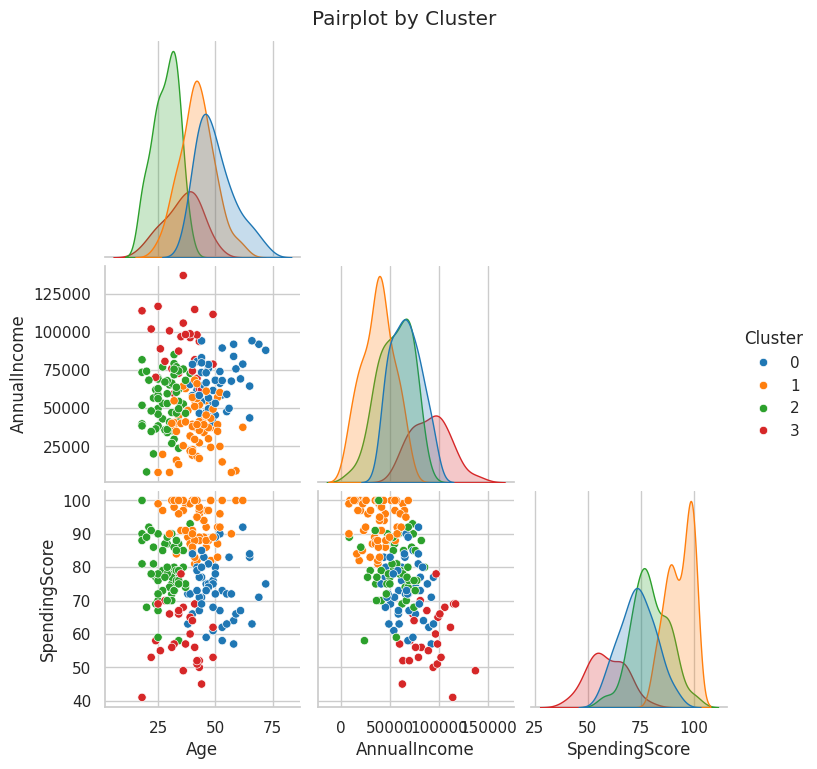

,Cluster,Age,AnnualIncome,SpendingScore
0,0,50.16,65660.94,73.01
1,1,42.79,37602.22,93.13
2,2,28.33,56282.85,80.17
3,3,35.06,91144.18,58.94


In [13]:
# Pairplot (sampling if needed)
sample = df.sample(n=200, random_state=42) if len(df)>200 else df
sns.pairplot(sample[features + ['Cluster']], hue='Cluster', palette='tab10', diag_kind='kde', corner=True)
plt.suptitle('Pairplot by Cluster', y=1.02)
plt.show()

# Centroids back to original scale
centroids_original = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_original, columns=features)
centroid_df['Cluster'] = range(chosen_k)
centroid_df = centroid_df[['Cluster'] + features]
centroid_df.round(2)


In [14]:
df.to_csv('clustered_customers.csv', index=False)
centroid_df.to_csv('cluster_centroids.csv', index=False)
print("Saved: clustered_customers.csv and cluster_centroids.csv")


Saved: clustered_customers.csv and cluster_centroids.csv


## 8) Insights & Recommendations

- Summary of clusters (interpret cluster centroids):
  - Cluster 0: [describe from centroid_df]
  - Cluster 1: ...
  (Replace above with numbers from centroid table)

- Actions:
  - Target high-spending, high-income clusters for premium product campaigns.
  - Offer loyalty programs / upsell strategies to medium-spending but high-income clusters.
  - Try retention campaigns and promotions for low-spending clusters.

- Note: If you receive the real `customer_data.csv`, re-run this notebook after replacing the data-loading cell. The clustering pipeline (scaling → elbow/silhouette → kmeans → PCA) will remain the same.
